In [52]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
from PIL import Image, ImageFilter, ImageDraw

## Implementing gaussian filter

### Following this tutorial: http://www.adeveloperdiary.com/data-science/computer-vision/applying-gaussian-smoothing-to-an-image-using-python-from-scratch/

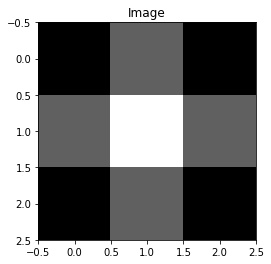

array([[0.36787944, 0.60653066, 0.36787944],
       [0.60653066, 1.        , 0.60653066],
       [0.36787944, 0.60653066, 0.36787944]])

In [9]:
def dnorm(x, mu, sd):
    return 1 / (np.sqrt(2 * np.pi) * sd) * np.e ** (-np.power((x - mu) / sd, 2) / 2)

def gaussian_kernel(size, sigma=1, verbose=False):
 
    kernel_1D = np.linspace(-(size // 2), size // 2, size)
    for i in range(size):
        kernel_1D[i] = dnorm(kernel_1D[i], 0, sigma)
    kernel_2D = np.outer(kernel_1D.T, kernel_1D.T)
 
    kernel_2D *= 1.0 / kernel_2D.max()
 
    if verbose:
        plt.imshow(kernel_2D, interpolation='none',cmap='gray')
        plt.title("Image")
        plt.show()
 
    return kernel_2D

gaussian_kernel(3, verbose=True)

### Convolution as per author...

Credits: http://www.adeveloperdiary.com/data-science/computer-vision/applying-gaussian-smoothing-to-an-image-using-python-from-scratch/

In [46]:
def convolution(image, kernel, average=False, verbose=False):
    if len(image.shape) == 3:
        print("Found 3 Channels : {}".format(image.shape))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        print("Converted to Gray Channel. Size : {}".format(image.shape))
    else:
        print("Image Shape : {}".format(image.shape))
 
    print("Kernel Shape : {}".format(kernel.shape))
 
    if verbose:
        plt.imshow(image, cmap='gray')
        plt.title("Image")
        plt.show()
 
    image_row, image_col = image.shape
    kernel_row, kernel_col = kernel.shape
 
    output = np.zeros(image.shape)
 
    pad_height = int((kernel_row - 1) / 2)
    pad_width = int((kernel_col - 1) / 2)
 
    padded_image = np.zeros((image_row + (2 * pad_height), image_col + (2 * pad_width)))
 
    padded_image[pad_height:padded_image.shape[0] - pad_height, pad_width:padded_image.shape[1] - pad_width] = image
 
    if verbose:
        plt.imshow(padded_image, cmap='gray')
        plt.title("Padded Image")
        plt.show()
 
    for row in range(image_row):
        for col in range(image_col):
            output[row, col] = np.sum(kernel * padded_image[row:row + kernel_row, col:col + kernel_col])
            if average:
                output[row, col] /= kernel.shape[0] * kernel.shape[1]
 
    print("Output Image size : {}".format(output.shape))
 
    if verbose:
        plt.imshow(output, cmap='gray')
        plt.title("Output Image using {}X{} Kernel".format(kernel_row, kernel_col))
        plt.show()
 
    return output

Found 3 Channels : (640, 600, 3)
Converted to Gray Channel. Size : (640, 600)
Kernel Shape : (15, 15)


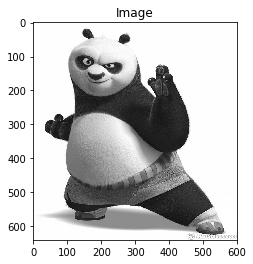

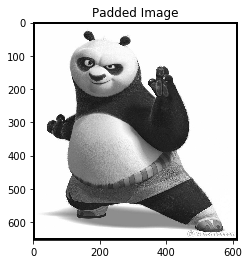

Output Image size : (640, 600)


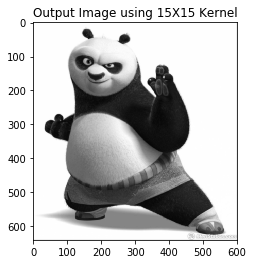

In [48]:
img = cv2.imread('panda.jpg')
k = gaussian_kernel(15)

np_panda = convolution(img, k, verbose=True)

In [50]:
def gaussian_blur(image, kernel_size, verbose=False):
    kernel = gaussian_kernel(kernel_size, sigma=math.sqrt(kernel_size), verbose=verbose)
    return convolution(image, kernel, average=True, verbose=verbose)

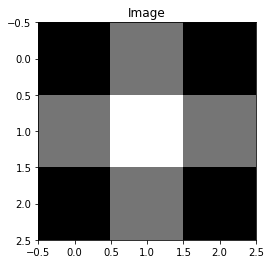

Found 3 Channels : (640, 600, 3)
Converted to Gray Channel. Size : (640, 600)
Kernel Shape : (3, 3)


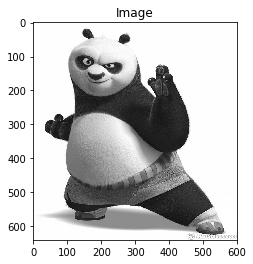

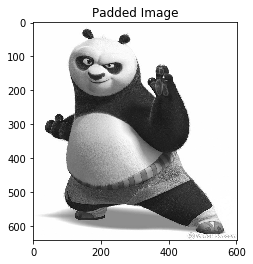

Output Image size : (640, 600)


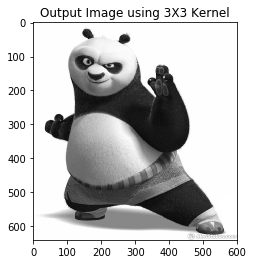

In [55]:
panda = cv2.imread('panda.jpg')
blur_panda = gaussian_blur(panda, 3, verbose=True)

Notes: the author uses the zero padding (fill borders with zeros) so the output image is the same size as the input image, this is known as **"Same Convolution"**

### Magnitude and orientation of a gradient

Credits (based on): http://www.adeveloperdiary.com/data-science/computer-vision/how-to-implement-sobel-edge-detection-using-python-from-scratch/    

In [56]:
def sobel_edge_detection(image, kernel, verbose=False):
    new_image_x = convolution(image, kernel, verbose)
 
    if verbose:
        plt.imshow(new_image_x, cmap='gray')
        plt.title("Horizontal Edge")
        plt.show()
 
    #Y sobel transposing the kernel
    new_image_y = convolution(image, np.flip(kernel.T, axis=0), verbose)
 
    if verbose:
        plt.imshow(new_image_y, cmap='gray')
        plt.title("Vertical Edge")
        plt.show()
 
    #Gradient magnitude is the square root of Gx + Gy a.k.a. sobel filter (derivative)
    gradient_magnitude = np.sqrt(np.square(new_image_x) + np.square(new_image_y))
 
    #Normalization...
    gradient_magnitude *= 255.0 / gradient_magnitude.max()
 
    if verbose:
        plt.imshow(gradient_magnitude, cmap='gray')
        plt.title("Gradient Magnitude")
        plt.show()
 
    return gradient_magnitude


In [57]:
sobel_kernel = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
sobel_kernel

array([[-1,  0,  1],
       [-2,  0,  2],
       [-1,  0,  1]])

Image Shape : (640, 600)
Kernel Shape : (3, 3)
Output Image size : (640, 600)


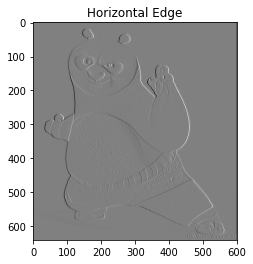

Image Shape : (640, 600)
Kernel Shape : (3, 3)
Output Image size : (640, 600)


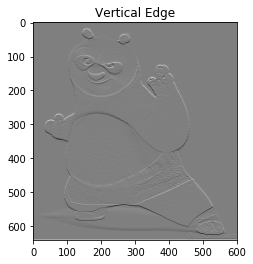

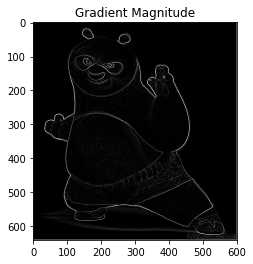

In [60]:
np_sobel_panda = sobel_edge_detection(blur_panda, sobel_kernel, verbose=True)

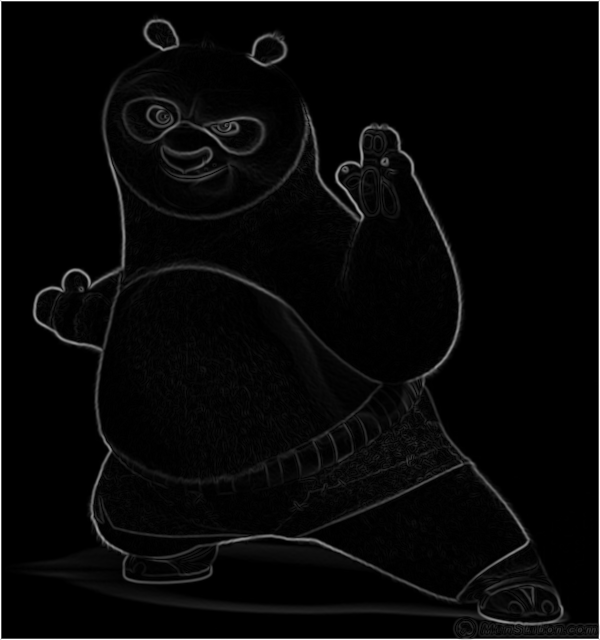

In [95]:
Image.fromarray(np_sobel_panda.astype(np.uint8))

## Gradient orientation

Credits (based on): http://www.adeveloperdiary.com/data-science/computer-vision/implement-canny-edge-detector-using-python-from-scratch/

We will calculcate theta (θ) which is the orientation of the gradient, using this equation: θ=tan^−1(GxGy)

We are asked to update sobel_edge_detection funct to include "convert to degrees" as theta is given in radians.

In [117]:
def sobel_edge_detection1(image, kernel, convert_to_degree=False, verbose=False):
    new_image_x = convolution(image, kernel, verbose)
 
    if verbose:
        plt.imshow(new_image_x, cmap='gray')
        plt.title("Horizontal Edge")
        plt.show()
 
    #Y sobel transposing the kernel
    new_image_y = convolution(image, np.flip(kernel.T, axis=0), verbose)
 
    if verbose:
        plt.imshow(new_image_y, cmap='gray')
        plt.title("Vertical Edge")
        plt.show()
 
    #Gradient magnitude is the square root of Gx + Gy a.k.a. sobel filter (derivative)
    gradient_magnitude = np.sqrt(np.square(new_image_x) + np.square(new_image_y))
 
    #Normalization...
    gradient_magnitude *= 255.0 / gradient_magnitude.max()
 
    if verbose:
        plt.imshow(gradient_magnitude, cmap='gray')
        plt.title("Gradient Magnitude")
        plt.show()
        
    gradient_direction = np.arctan2(new_image_y, new_image_x)

    if convert_to_degree:
        gradient_direction = np.rad2deg(gradient_direction)
        gradient_direction += 180
        
        if verbose:
            print("Updated gradient direction in degrees...")
            print("This will return 2 np arrays: gradient_magnitude, gradient_direction")
            gradient_direction
            
        return gradient_magnitude, gradient_direction
 
    return gradient_magnitude


Image Shape : (640, 600)
Kernel Shape : (3, 3)
Output Image size : (640, 600)


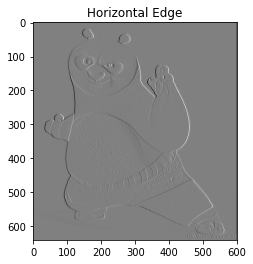

Image Shape : (640, 600)
Kernel Shape : (3, 3)
Output Image size : (640, 600)


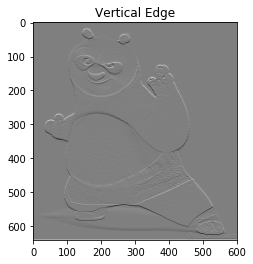

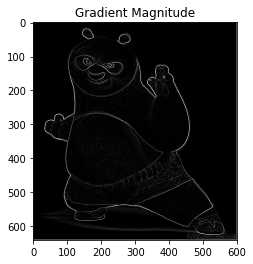

In [98]:
np_sobel_panda1 = sobel_edge_detection1(blur_panda, sobel_kernel, verbose=True)

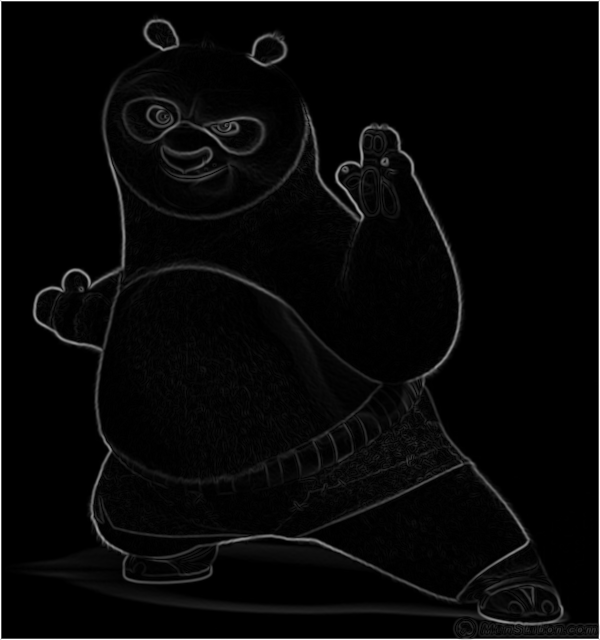

In [99]:
Image.fromarray(np_sobel_panda1.astype(np.uint8))

Just for fun (and comparation) printing the __"Orthogonal gradient vectors"__ this code is my authoring and not part of the tutorial (but enyojable to to include). I finished the orthogonal excercise before this, thus curious what the output would be...

In [105]:
def calculaTheta(ang, size=25):
    
    if ang < 0 : ang = 360 + ang
    
    if (ang < 20): return (-size,0) #0 deg
    elif (ang < 65): return (-size,+size) # 45 deg
    elif (ang < 110): return (0, +size) # 90 deg
    elif (ang < 155): return (+size, +size) # 135 deg
    elif (ang < 200): return (+size, 0) # 180 deg
    elif (ang < 245): return (+size, size) # 225 deg
    elif (ang < 290): return (0, size) # 270 deg
    elif (ang < 335): return (-size, -size) # 315 deg
    else: ang = 0

In [143]:
sed1 = sobel_edge_detection1(blur_panda, sobel_kernel, convert_to_degree=True, verbose=False)

Image Shape : (640, 600)
Kernel Shape : (3, 3)
Output Image size : (640, 600)
Image Shape : (640, 600)
Kernel Shape : (3, 3)
Output Image size : (640, 600)


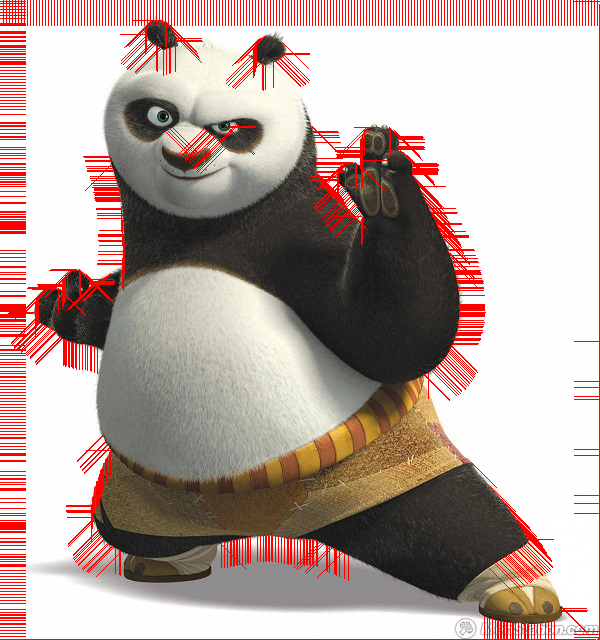

In [164]:
def drawGradients(image, sobel_img, theta_img ,paint_step = 3, treshold=100):
    canvas = ImageDraw.Draw(image)
    #np_temp_sobel = sobel_edge_detection1(blur_panda, sobel_kernel, convert_to_degree=True, verbose=False)
    
    np_orth_panda = sobel_img.astype(np.uint8)
    np_tetha = theta_img.astype(np.uint8)
    c,r = np_orth_panda.shape
    
    ii = 0
    for i in range(c):
        for j in range(r):
            if(np_orth_panda[i, j] > treshold):
                if(ii == paint_step):
                    thetaj, thetai = calculaTheta(np_tetha [i,j]) 
                    canvas.line([(j, i), (j+thetaj, i+thetai)] , fill="#ff0000", width=1)
                    ii=0
                ii+=1
    return image


color_panda = Image.open("panda.jpg")
drawGradients(color_panda, sed1[0], sed1[1])

#color_panda

## Apply Non-max suppresion

### Remove reduntand nad or duplicate edges from sobel edge detector

Credits: http://www.adeveloperdiary.com/data-science/computer-vision/implement-canny-edge-detector-using-python-from-scratch/

In [70]:
def non_max_suppression(gradient_magnitude, gradient_direction, verbose):
    image_row, image_col = gradient_magnitude.shape
 
    output = np.zeros(gradient_magnitude.shape)
 
    PI = 180
 
    #Skipping borders...
    for row in range(1, image_row - 1):
        #idem...
        for col in range(1, image_col - 1):
            #getting the direction of the gradient in degrees as we previously prepared for...
            direction = gradient_direction[row, col]
 
            #Here we are chosing pixels to compare (top, left, bottom or right (not necessarely in this order))
            if (0 <= direction < PI / 8) or (15 * PI / 8 <= direction <= 2 * PI):
                before_pixel = gradient_magnitude[row, col - 1]
                after_pixel = gradient_magnitude[row, col + 1]
 
            elif (PI / 8 <= direction < 3 * PI / 8) or (9 * PI / 8 <= direction < 11 * PI / 8):
                before_pixel = gradient_magnitude[row + 1, col - 1]
                after_pixel = gradient_magnitude[row - 1, col + 1]
 
            elif (3 * PI / 8 <= direction < 5 * PI / 8) or (11 * PI / 8 <= direction < 13 * PI / 8):
                before_pixel = gradient_magnitude[row - 1, col]
                after_pixel = gradient_magnitude[row + 1, col]
 
            else:
                before_pixel = gradient_magnitude[row - 1, col - 1]
                after_pixel = gradient_magnitude[row + 1, col + 1]
 
            if gradient_magnitude[row, col] >= before_pixel and gradient_magnitude[row, col] >= after_pixel:
                output[row, col] = gradient_magnitude[row, col]
 
    if verbose:
        plt.imshow(output, cmap='gray')
        plt.title("Non Max Suppression")
        plt.show()
 
    return output

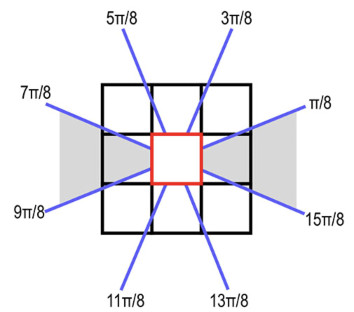

In [71]:
Image.open("non-max-sup-neig.jpg")

Image Shape : (640, 600)
Kernel Shape : (3, 3)
Output Image size : (640, 600)
Image Shape : (640, 600)
Kernel Shape : (3, 3)
Output Image size : (640, 600)
Image Shape : (640, 600)
Kernel Shape : (3, 3)
Output Image size : (640, 600)


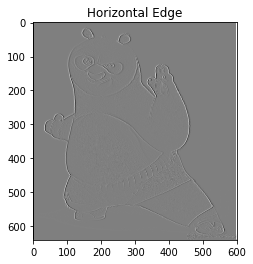

Image Shape : (640, 600)
Kernel Shape : (3, 3)
Output Image size : (640, 600)


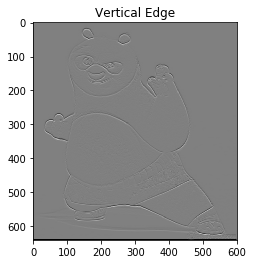

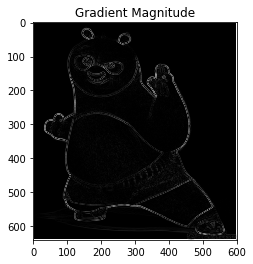

Updated gradient direction in degrees...
This will return 2 np arrays: gradient_magnitude, gradient_direction


In [100]:
sobel_panda1 = sobel_edge_detection1(blur_panda, sobel_kernel)
gradient_magnitude, gradient_direction = sobel_edge_detection1(sobel_panda1, sobel_kernel, convert_to_degree=True, verbose=True)

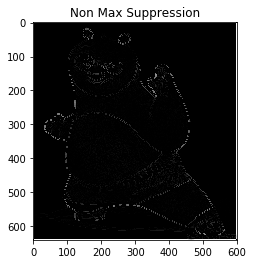

In [75]:
non_max_panda = non_max_suppression(gradient_magnitude, gradient_direction, verbose=True)

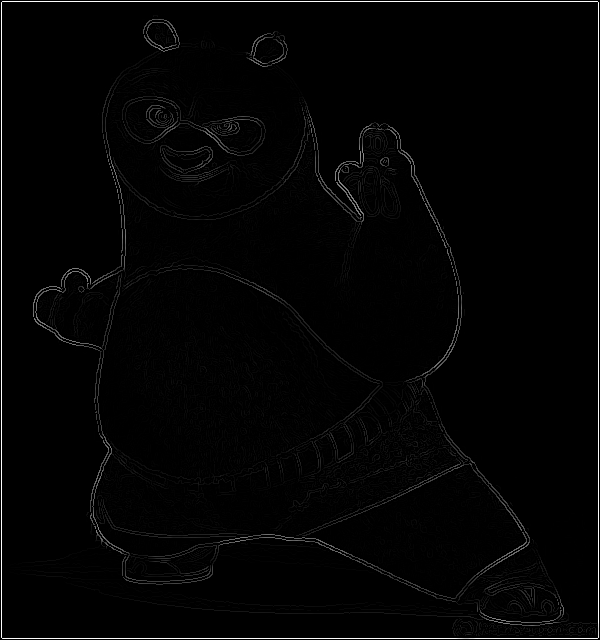

In [102]:
Image.fromarray(non_max_panda.astype(np.uint8))

## Apply Hysteresis treshold

### Divided in 2 :  Treshold & Hysteresis 

Credits (based on): http://www.adeveloperdiary.com/data-science/computer-vision/implement-canny-edge-detector-using-python-from-scratch/

**Treshold** Any pixrel with value higher than "high" value is 255. Between low and High = weak. Everything else is 0.

In [80]:
def threshold(image, low, high, weak, verbose=False):
 
    output = np.zeros(image.shape)
 
    strong = 255
 
    strong_row, strong_col = np.where(image >= high)
    weak_row, weak_col = np.where((image <= high) & (image >= low))
 
    output[strong_row, strong_col] = strong
    output[weak_row, weak_col] = weak
 
    if verbose:
        plt.imshow(output, cmap='gray')
        plt.title("threshold")
        plt.show()
 
    return output

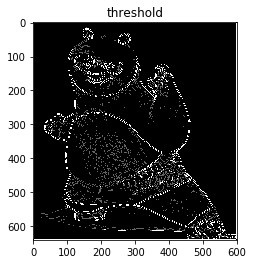

In [82]:
weak_val = 100
treshold_panda = threshold(non_max_panda, 5, 20, weak=weak_val, verbose=True)

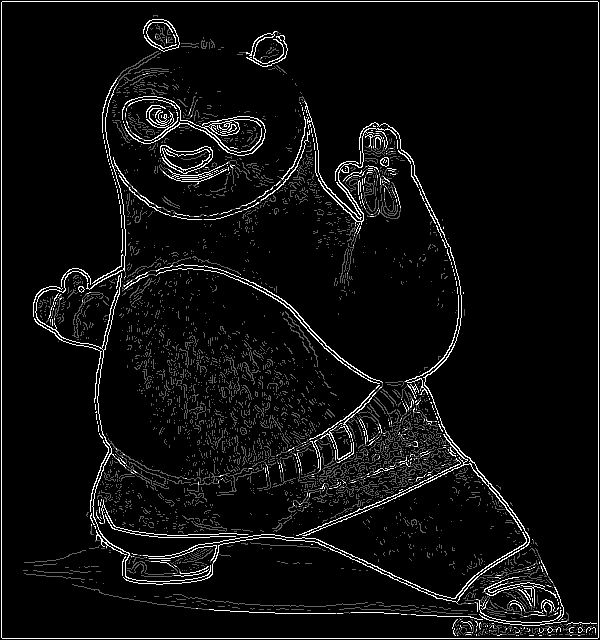

In [103]:
Image.fromarray(treshold_panda.astype(np.uint8))

**Hysteresis** the phenomenon in which the value of a physical property lags behind changes in the effect causing it, as for instance when magnetic induction lags behind the magnetizing force.

Basically the job of Hysteresis is to spot the "weak" pixels that can be edges and drop the rest.
How? are they connected to the already defined as "edge" pixels?

We need to scan from all corners to make sure we don't miss any weak pixels connected to strong

In [87]:
def hysteresis(image, weak, verbose=False):
    image_row, image_col = image.shape
 
    top_to_bottom = image.copy()
 
    for row in range(1, image_row):
        for col in range(1, image_col):
            if top_to_bottom[row, col] == weak:
                if top_to_bottom[row, col + 1] == 255 or top_to_bottom[row, col - 1] == 255 or top_to_bottom[row - 1, col] == 255 or top_to_bottom[
                    row + 1, col] == 255 or top_to_bottom[
                    row - 1, col - 1] == 255 or top_to_bottom[row + 1, col - 1] == 255 or top_to_bottom[row - 1, col + 1] == 255 or top_to_bottom[
                    row + 1, col + 1] == 255:
                    top_to_bottom[row, col] = 255
                else:
                    top_to_bottom[row, col] = 0
 
    bottom_to_top = image.copy()
 
    for row in range(image_row - 1, 0, -1):
        for col in range(image_col - 1, 0, -1):
            if bottom_to_top[row, col] == weak:
                if bottom_to_top[row, col + 1] == 255 or bottom_to_top[row, col - 1] == 255 or bottom_to_top[row - 1, col] == 255 or bottom_to_top[
                    row + 1, col] == 255 or bottom_to_top[
                    row - 1, col - 1] == 255 or bottom_to_top[row + 1, col - 1] == 255 or bottom_to_top[row - 1, col + 1] == 255 or bottom_to_top[
                    row + 1, col + 1] == 255:
                    bottom_to_top[row, col] = 255
                else:
                    bottom_to_top[row, col] = 0
 
    right_to_left = image.copy()
 
    for row in range(1, image_row):
        for col in range(image_col - 1, 0, -1):
            if right_to_left[row, col] == weak:
                if right_to_left[row, col + 1] == 255 or right_to_left[row, col - 1] == 255 or right_to_left[row - 1, col] == 255 or right_to_left[
                    row + 1, col] == 255 or right_to_left[
                    row - 1, col - 1] == 255 or right_to_left[row + 1, col - 1] == 255 or right_to_left[row - 1, col + 1] == 255 or right_to_left[
                    row + 1, col + 1] == 255:
                    right_to_left[row, col] = 255
                else:
                    right_to_left[row, col] = 0
 
    left_to_right = image.copy()
 
    for row in range(image_row - 1, 0, -1):
        for col in range(1, image_col):
            if left_to_right[row, col] == weak:
                if left_to_right[row, col + 1] == 255 or left_to_right[row, col - 1] == 255 or left_to_right[row - 1, col] == 255 or left_to_right[
                    row + 1, col] == 255 or left_to_right[
                    row - 1, col - 1] == 255 or left_to_right[row + 1, col - 1] == 255 or left_to_right[row - 1, col + 1] == 255 or left_to_right[
                    row + 1, col + 1] == 255:
                    left_to_right[row, col] = 255
                else:
                    left_to_right[row, col] = 0
 
    final_image = top_to_bottom + bottom_to_top + right_to_left + left_to_right
 
    final_image[final_image > 255] = 255
    
    if verbose:
        plt.imshow(final_image, cmap='gray')
        plt.title("Canny Filter")
        plt.show()
 
    return final_image

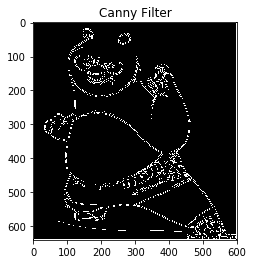

In [90]:
np_hysteresis = hysteresis(treshold_panda, weak_val, verbose=True)

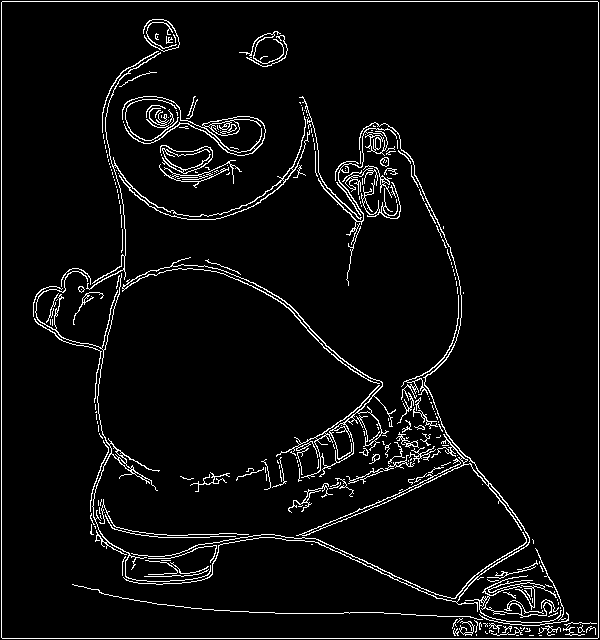

In [93]:
canny_panda = Image.fromarray(np_hysteresis.astype(np.uint8))
canny_panda

## Putting all together...

Bonus practice :)

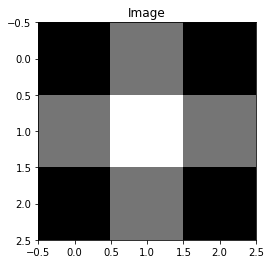

Found 3 Channels : (480, 207, 3)
Converted to Gray Channel. Size : (480, 207)
Kernel Shape : (3, 3)


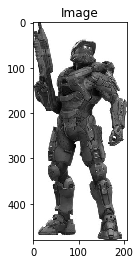

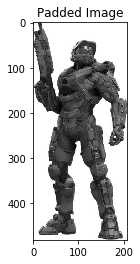

Output Image size : (480, 207)


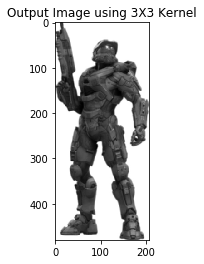

Image Shape : (480, 207)
Kernel Shape : (3, 3)
Output Image size : (480, 207)


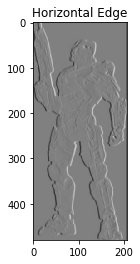

Image Shape : (480, 207)
Kernel Shape : (3, 3)
Output Image size : (480, 207)


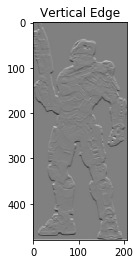

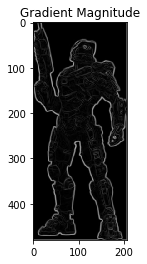

Image Shape : (480, 207)
Kernel Shape : (3, 3)
Output Image size : (480, 207)


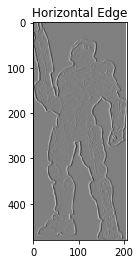

Image Shape : (480, 207)
Kernel Shape : (3, 3)
Output Image size : (480, 207)


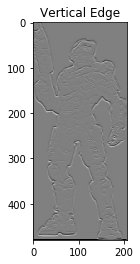

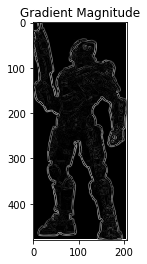

Updated gradient direction in degrees...
This will return 2 np arrays: gradient_magnitude, gradient_direction


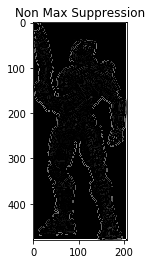

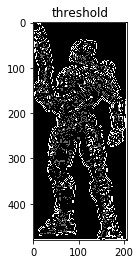

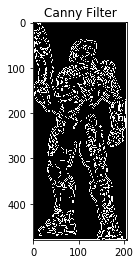

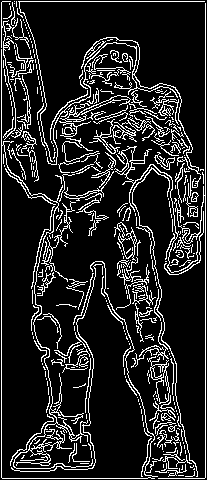

In [173]:
bonus_img = cv2.imread('chief.jpg')

def canny_filter(image):
    weak_val = 100
    gauss_k = 3
    sobel_kernel = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    #k = gaussian_kernel(15)
    
    
    #np_conv = convolution(image, k, verbose=True)
    np_blur = gaussian_blur(image, gauss_k, verbose=True)
    np_sobel = sobel_edge_detection(np_blur, sobel_kernel, verbose=True)
    #np_sobel_1 = sobel_edge_detection1(np_blur, sobel_kernel, verbose=True)
    #np_sobel_1 = sobel_edge_detection1(np_blur, sobel_kernel)
    gradient_magnitude, gradient_direction = sobel_edge_detection1(np_sobel, sobel_kernel, convert_to_degree=True, verbose=True)
    #grads = drawGradients(Image.fromarray(image.astype(np.uint8)), np_blur, gradient_direction)
    #grads.show()
    np_non_max = non_max_suppression(gradient_magnitude, gradient_direction, verbose=True)
    np_treshold = threshold(np_non_max, 5, 20, weak=weak_val, verbose=True)
    np_hysteresis = hysteresis(np_treshold, weak_val, verbose=True)
    
    return Image.fromarray(np_hysteresis.astype(np.uint8))

canny_filter(bonus_img)

Found 3 Channels : (480, 207, 3)
Converted to Gray Channel. Size : (480, 207)
Kernel Shape : (3, 3)
Output Image size : (480, 207)
Image Shape : (480, 207)
Kernel Shape : (3, 3)
Output Image size : (480, 207)
Image Shape : (480, 207)
Kernel Shape : (3, 3)
Output Image size : (480, 207)


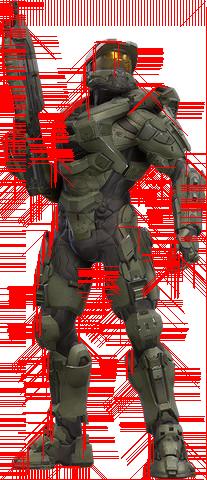

In [177]:
color_chief = Image.open("chief.jpg")
blur_chief = gaussian_blur(cv2.imread('chief.jpg'), 3)
sed2 = sobel_edge_detection1(blur_chief, sobel_kernel, convert_to_degree=True, verbose=False)
drawGradients(color_chief, sed2[0], sed2[1])